# Population Receptive Field mapping

It's important to understand the responses of single units (in the case of fMRI, these units are voxels). How well we can predict the responses of a voxel is our measure of how well we understand the computations being performed in the voxel. For example, in this framework, we can compare the performance of two models in explaining the data. 

In the examples shown in this brief notebook, you will investigate whether we can discriminate a response from a voxel with an inhibition-field from a voxel without an inhibition-field. Along the way, you will learn about population receptive fields and fitting. You'll also become acquainted with the concept of signal to noise ratio. 

This workshop demo is implemented in a JuPyteR Notebook. Notebooks are composed of two types of cells: MarkDown cells, like the one you're reading from now, have text in them. Code cells on the other hand, declare code fragments - in this case python. The code cells can generate images and movies, so that we have a single place to engage with text, code, and research output. The nice thing about this notebook format is that you can change the code and thereby investigate how this changes the underlying mechanisms, because changes in the code will be reflected in changes to the figures.

Lastly, if your interest is piqued by this notebook and you want to learn/do more, I seriously recommend the [data science handbook](https://jakevdp.github.io/PythonDataScienceHandbook/), which is built up out of notebooks just like this one.

In [1]:
# This is a comment, it will not be executed
# everything in this cell is important, 
# because it imports functionality that we'll use in the rest of the notebook

# These are general and plotting imports
import ctypes, multiprocessing
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

# These are pRF-specific imports
import popeye.og_hrf as og # this is a receptive field model without inhibition
import popeye.dog as dog # this is a receptive field model WITH inhibition
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus, simulate_bar_stimulus

## Population receptive field model definition

The nice thing about trying to understand the BOLD time-course with our model-based analysis, is that we have a fully parametrized model. This means that we can vary the parameters to create specific model instances - and, very importantly, that we can fit these parameters to our data. 
You will be looking at both. But first, let's have a first look at how a receptive field model works, and what the different parameters are, starting with a simple 1D-example:

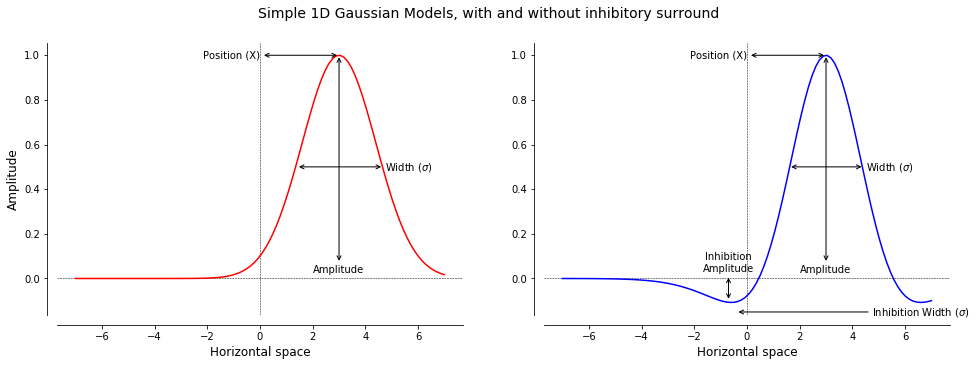

In [2]:
# this function defines a one-dimensional gaussian receptive field
def gauss_rf_1d(x, x0=0, s=1):
    return np.exp(-((x-x0)**2)/(2*s**2))

x = np.linspace(-7,7,100)
f = plt.figure(figsize=(16,5))
f.suptitle('Simple 1D Gaussian Models, with and without inhibitory surround',fontsize=14)
# define and plot a standard, gaussian receptive field in 1D
s1 = f.add_subplot(121)
plt.axvline(0, c='k', ls='--', lw=0.5)
plt.axhline(0, c='k', ls='--', lw=0.5)

plt.plot(x, gauss_rf_1d(x, x0=3.0, s=1.4), 'r')
plt.xlabel('Horizontal space',fontsize=12)
plt.ylabel('Amplitude',fontsize=12);
# let's draw some arrows
plt.annotate("Amplitude", xy=(3.0, 1.0), xytext=(3, 0.025), xycoords=("data", "data"), 
        arrowprops=dict(arrowstyle="<->"), horizontalalignment='center')
plt.annotate("Width ($\sigma$)", xy=(1.4, 0.5), xytext=(4.75, 0.5), xycoords=("data", "data"), 
        arrowprops=dict(arrowstyle="<->"), horizontalalignment='left', verticalalignment='center')
plt.annotate("Position (X)", xy=(3.0, 1), xytext=(0,1), xycoords=("data", "data"), 
        arrowprops=dict(arrowstyle="<->"), horizontalalignment='right', verticalalignment='center')

# and, let's now implement an inhibitory surround
s2 = f.add_subplot(122, sharey=s1)
plt.axvline(0, c='k', ls='--', lw=0.5)
plt.axhline(0, c='k', ls='--', lw=0.5)

plt.plot(x, 1.5*gauss_rf_1d(x, x0=3.0, s=1.4)-0.5*gauss_rf_1d(x, x0=3.0, s=2.4), 'b')
plt.xlabel('Horizontal space',fontsize=12)
# let's draw some arrows
plt.annotate("Amplitude", xy=(3.0, 1.0), xytext=(3, 0.025), xycoords=("data", "data"), 
        arrowprops=dict(arrowstyle="<->"), horizontalalignment='center')
plt.annotate("Width ($\sigma$)", xy=(1.6, 0.5), xytext=(4.5, 0.5), xycoords=("data", "data"), 
        arrowprops=dict(arrowstyle="<->"), horizontalalignment='left', verticalalignment='center')
plt.annotate("Position (X)", xy=(3.0, 1), xytext=(0,1), xycoords=("data", "data"), 
        arrowprops=dict(arrowstyle="<->"), horizontalalignment='right', verticalalignment='center')
plt.annotate("Inhibition\nAmplitude", xy=(-0.7, -0.1), xytext=(-0.7,.07), xycoords=("data", "data"), 
        arrowprops=dict(arrowstyle="<->"), horizontalalignment='center', verticalalignment='center')
plt.annotate("Inhibition Width ($\sigma$)", xy=(-0.4, -0.15), xytext=(4.75, -0.15), xycoords=("data", "data"), 
        arrowprops=dict(arrowstyle="->"), horizontalalignment='left', verticalalignment='center')

sns.despine(fig=f, offset=10)

#### Question
Have a look at the figure above. What are the differences between the two receptive fields? And, what are the *2* parameters that define this difference? Important: How are these receptive fields similar?

**Advanced question:** Can you find where in the code this difference was implemented? What were the values of the two parameters?

## Extension to 2D

Let's extend this concept to 2Dimensional space, because visual space is 2-dimensional of course. 
Below, we're defining a couple of functions to work with 2-dimensional receptive fields. (Not too important for you to read :-))

In [3]:
def gauss_rf_2d(x, y, x0=0, y0=0, s=1, theta=0, ar=1):
    """gauss_rf_2d takes 2D arrays x and y and produces a pRF with given parameters"""
    xr = (x-x0) * np.cos(theta) + (y-y0) * np.sin(theta)
    yr = -(x-x0) * np.sin(theta) + (y-y0) * np.cos(theta)
    return np.exp(-(xr**2 + ar**2 * yr**2)/(2*s**2))

def plot_RF(X, Y, Z, ax, vmin=-0.25, n_levels=10, fs=14, title='', inits=(48, 74)):
    """plot_RF plots a pRF Z for X and Y horizontal and vertical space.
    It takes the axis in which to plot as a necessary argument ax."""
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    vmax=np.max(Z), vmin=vmin, cmap=cm.viridis)

    # Adjust the limits, ticks and view angle
    ax.set_zlim(-0.1,0.6)
    ax.view_init(inits[0], inits[1])
    ax.set_title(title, fontsize=fs)

# Our 2-dimensional distribution will be over variables X and Y
N = 75
X = np.linspace(-20, 20, N)
Y = np.linspace(-20, 20, N)
X, Y = np.meshgrid(X, Y)

### Model parameters
In the code cells below you will see that models, and parameters for our models are declared. Read through the code and try to understand what they mean

In [4]:
### MODEL PARAMETERS
## define the parameters for our pRF(s) 
x = -2.24              # Horizontal position of pRF center
y = 2.58               # Vertical position of pRF center
sigma = 3.74           # Width of pRF center
sigma_ratio = 1.5      # Ratio of pRF surround width to pRF center width
volume_ratio = 1.2     # Ratio of pRF surround amplitude to pRF center amplitude (encoded as volume here)
beta = 0.55            # pRF height (Amplitude, also called beta)

### Visualize models
In the code cells we plot the two different models, with and without inhibition. Try to use the `inits` argument to the plotting function to rotate around the plotted receptive fields. 

Also, you can now see how changing the parameters influences what they look like!

**Advanced Question:** As you can see, there are also other options that we can change in the `gauss_rf_2d` function. These are the orientation (`theta`) and aspect ratio (`ar`) of the gauss. Feel free to play around with those in the visualizations below!

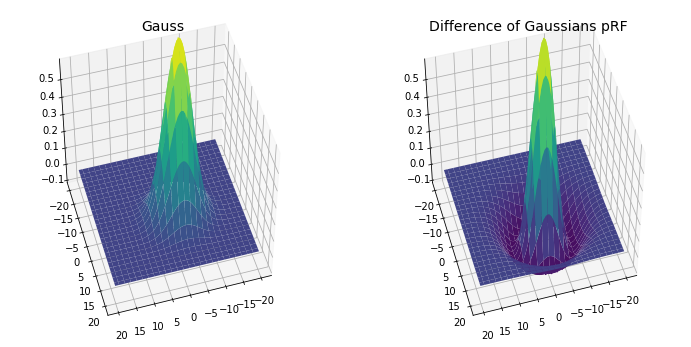

In [140]:
fig = plt.figure(figsize=(12,6))

# Create a standard gaussian receptive field
Z = gauss_rf_2d(X, Y, x0=x, y0=y, s=sigma, theta=0, ar=1)

# Create a surface plot and projected filled contour plot under it.
ax1 = fig.add_subplot(121, projection='3d')
plot_RF(X, Y, Z, ax1, title='Gauss')

# Gaussian receptive field with inhibitory surround:
# a Difference of Gaussians model
Z_pos = (1+volume_ratio) * gauss_rf_2d(X, Y, x0=x, y0=y, s=sigma, theta=0, ar=1)
Z_neg = -volume_ratio * gauss_rf_2d(X, Y, x0=x, y0=y, s=sigma*sigma_ratio, theta=0, ar=1)
Z = Z_pos + Z_neg

ax2 = fig.add_subplot(122, projection='3d')
plot_RF(X, Y, Z, ax2, title='Difference of Gaussians pRF')

## Simulating an actual (model) experiment!

### First: Stimulus design

Population receptive field mapping is usually performed with 'sweeping bar' stimuli. This means that a bar-shaped stimulus is swept across the screen in different directions. Of course, this is an fMRI experiment, so that everything happens very slowly. 

Let's first create a stimulus design, in which bar stimulus sweeps are alternated with blanks. The result of creating a stimulus like this, is that we have a 3D experimental design matrix. The dimensions stand for horizontal and vertical space, and time. We'll plot the resulting experimental design matrix as a movie, so that you'll get an intuition for what our model observer (and his/her receptive fields) will see. 

Note that we'll also be using this experimental design in our analysis, later!

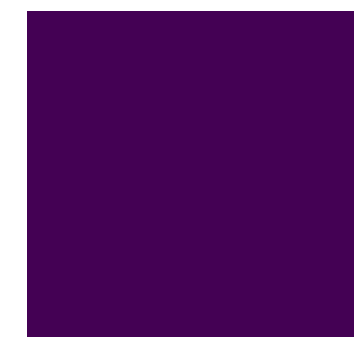

In [153]:
# stimulus for creating time-courses
### STIMULUS
sweeps = np.array([-1,45,135,-1,225,315,-1]) # in degrees, -1 is blank
# we could make it longer by adding these to sweeps: 0,90,-1,180,270,-1
# but that will make fitting slower, later. 
## create sweeping bar stimulus
bar = simulate_bar_stimulus(100, 100, 40, 40, sweeps, 30, 30, 20, 0.67)
stimulus = VisualStimulus(bar, 50, 25, 0.50, 1.0, ctypes.c_int16)

# plot the stimulus as it traverses the screen
fig = plt.figure(figsize=(6, 6))
ims = []
for t in range(stimulus.stim_arr.shape[-1]):
    im = plt.imshow(stimulus.stim_arr[...,t], animated=True, cmap='viridis', interpolation='bicubic');
    plt.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=80, blit=True, repeat_delay=1500)
ani

### Actual analysis

Now, we can use our model experiment to stimulate our model receptive fields, in a simulation of an experimental recording. We can run the same experiment for different model receptive fields, and then investigate their differences. Do the different models produce different BOLD time-courses?


Later, we will add noise of a specific level, so that we can investigate whether we can still find differences between two models.

For this demo, we'll be using the nice python pRF fitting package popeye, because implementing our own here would be a bit too much for a two-hour workshop. 

First, we'll have a look at how these receptive fields activate when we play our movie to them. What we do, is that we multiply our stimulus design matrix with the pRF for each timepoint. This gives us a time series of single values each representing the overlap between stimulus and pRF.

In [73]:
### MODEL PARAMETERS - REPEATED HERE
## define the parameters for our pRF(s) 
x = -2.24              # Horizontal position of pRF center
y = 2.58               # Vertical position of pRF center
sigma = 3.74           # Width of pRF center
sigma_ratio = 1.5      # Ratio of pRF surround width to pRF center width
volume_ratio = 1.2     # Ratio of pRF surround amplitude to pRF center amplitude (encoded as volume here)
beta = 0.55            # pRF height (Amplitude, also called beta)

### THESE PARAMETERS ARE IMPORTANT FOR BOLD-LEVEL SIMULATIONS

hrf_delay = 0          # fMRI: the HRF can vary between voxels: we'll leave it at 0
baseline = -0.28       # baseline, was 0 in plots above, but 
                       # for fMRI recordings (and later in this notebook) this is important

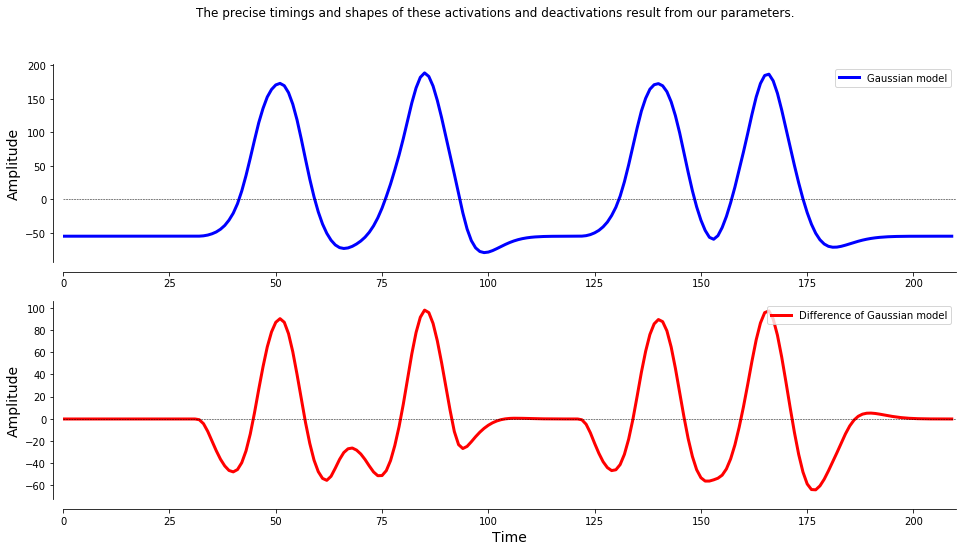

In [84]:
## initialize the gaussian and difference of gaussian models
## and create the time-series for the invented pRF estimate
og_model = og.GaussianModel(stimulus, utils.spm_hrf)
og_data = og_model.generate_prediction(x, y, sigma, hrf_delay, beta, baseline)

dog_model = dog.DifferenceOfGaussiansModel(stimulus, utils.spm_hrf)
dog_model.hrf_delay = hrf_delay
dog_data = dog_model.generate_prediction(x, y, sigma, sigma_ratio, volume_ratio, beta, baseline)/200

## plot the noise-free simulations
f = plt.figure(figsize=(16,8))
f.suptitle('The precise timings and shapes of these activations and deactivations result from our parameters.')

s1 = f.add_subplot(211)
s1.axhline(0, c='k', ls='--', lw=0.5)
s1.plot(og_data,c='b',lw=3,label='Gaussian model',zorder=1)
s1.set_ylabel('Amplitude',fontsize=14)
s1.set_xlim(0,stimulus.stim_arr.shape[-1])
s1.legend(loc=1)
s2 = f.add_subplot(212)
s2.axhline(0, c='k', ls='--', lw=0.5)
s2.plot(dog_data,c='r',lw=3,label='Difference of Gaussian model',zorder=1)
# note the weird scaling of the dog time-course. 
# this is something that we inherit from popeye, the fitting package
s2.set_xlabel('Time',fontsize=14)
s2.set_ylabel('Amplitude',fontsize=14)
s2.set_xlim(0,stimulus.stim_arr.shape[-1])
s2.legend(loc=1)

sns.despine(fig=f, offset=10)

#### Questions
Try to get an intuition regarding how the above time-courses are dependent on specific stimulus parameters by changing some of the parameters, like the `x` and `y` position of the pRFs. Do you see shifts, amplifications, etc?

### Fitting the pRFs

In the code cell below we're implementing a few functions that 1. add noise to our simulations, and 2. fit the noisy signals with a specific model. You can read through the code, but it's not too important. 

Note that fitting models like this is hard work for a computer. In the following analyses, you might have to wait a while before you can interpret the results. 

In [154]:
def create_one_sim(data, noise_level):
    noisy_data = data + np.random.randn(len(data))*data.std()*noise_level
    return noisy_data

def fit_one_sim(data, model, stimulus, verbose=1):
    ## define search grids
    # these define min and max of the edge of the initial brute-force search. 
    x_grid = (-10,10)
    y_grid = (-10,10)
    s_grid = (1/stimulus.ppd + 0.25,5.25)
    sr_grid = (1.5,4.5)
    vr_grid = (0.0,1.5)
    h_grid = (-1.0,1.0)

    ## define search bounds
    # these define the boundaries of the final gradient-descent search.
    x_bound = (-18.0,18.0)
    y_bound = (-18.0,18.0)
    s_bound = (1/stimulus.ppd, 12.0) # smallest sigma is a pixel
    sr_bound = (1.1, 6.0) 
    vr_bound = (0,3.0)
    b_bound = (1e-8,None)
    u_bound = (None,None)
    h_bound = (-3.0,3.0)
        
    ## fit the response
    print('Fitting ' + type(model).__name__)

    if type(model).__name__ == 'GaussianModel':
        ## package the grids and bounds
        grids = (x_grid, y_grid, s_grid, h_grid)
        bounds = (x_bound, y_bound, s_bound, h_bound, b_bound, u_bound,)
        # fit
        fit = og.GaussianFit(model, data, grids, bounds, Ns=5,
                         voxel_index=(1,2,3), auto_fit=True, verbose=1)
    elif type(model).__name__ == 'DifferenceOfGaussiansModel':
        ## package the grids and bounds
        grids = (x_grid, y_grid, s_grid, sr_grid, vr_grid)
        bounds = (x_bound, y_bound, s_bound, sr_bound, vr_bound, b_bound, u_bound,)
        # fit
        fit = dog.DifferenceOfGaussiansFit(model, data, grids, bounds, Ns=5,
                         voxel_index=(1,2,3), auto_fit=True, verbose=verbose)        
    return fit

### Specifying noise levels and what to fit
In the first cell below, you can specify 
1. the noise level to use
2. which dataset to fit (OG or DoG)
3. which model to use for the fit (OG or DoG)

The idea is that you try to see what each of the models can do that the other can't. Try, for example, to fit the DoG data with the OG data. 

In [161]:
# noise level for simulations. Defined as fraction of data std, higher is more noisy, lower is less noisy
noise_level = 1.0     
# here, we can select whether to use OG or DoG data
data2use = 'OG'
fit2use = 'DoG'

### Running the simulation and fit
In the cell below, we pretend to perform an experiment by creating noisy "data". This is our original modeled data - see above - with noise of amplitude `noise_level` added. Then, we will actually fit the pRF parameters using the generated noisy data. 

We also create a separate dataset, with different noise. You can think of this as a separate measurement from the same voxel. That is, its underlying signal is the same, but the measurement noise is different. With this extra data, we can calculate the cross-validated R$^{2}$ - this measure is robust to overfitting, whereas the R$^{2}$ of the fit data *is*.
This is of importance because, as you saw above, the DoG model has two extra parameters: It would be more prone to overfitting than the OG model which has fewer parameters. For more information on overfitting, and how to avoid it, see the [scikit-learn website](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html).

In [162]:
# fill in data dependent on the settings above
if data2use == 'OG':
    present_data = og_data
elif data2use == 'DoG':
    present_data = dog_data

if fit2use == 'OG':
    present_model = og_model
elif fit2use == 'DoG':
    present_model = dog_model

# we create noisy data on top of our simulated time-courses
# once to fit on, and once to test on: cross-validated estimation is important!
noisy_data = create_one_sim(data=present_data, noise_level=noise_level)
noisy_test_data = create_one_sim(data=present_data, noise_level=noise_level)

# the actual fit. 
# here, we can select whether to fit using an OG or DoG model
fit = fit_one_sim(noisy_data, 
                  present_model, stimulus, verbose=0)

# and quantify the CV R^2
cv_rsq = 1.0 - np.sum((fit.prediction - noisy_test_data)
                              ** 2) / np.sum(noisy_test_data**2)

Fitting DifferenceOfGaussiansModel


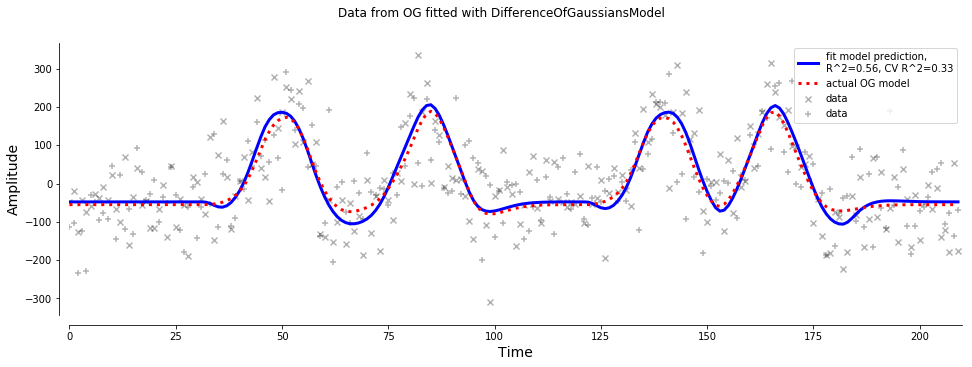

In [163]:
## plot the results
f = plt.figure(figsize=(16,5))
f.suptitle('Data from {data} fitted with {model}'.format(data=data2use, model=type(present_model).__name__))
plt.scatter(range(len(fit.data)), fit.data, c='k', label='data', alpha=0.3, marker='x')
plt.scatter(range(len(fit.data)), noisy_test_data, c='k', label='data', alpha=0.3, marker='+')

# fits and model timecourses
if fit2use == 'DoG':
    fit_color = 'b'
elif fit2use == 'OG':
    fit_color = 'r'
    
plt.plot(fit.prediction, c=fit_color,lw=3,label='fit model prediction,\nR^2=%1.2f, CV R^2=%1.2f'%(fit.rsquared, cv_rsq))

if data2use == 'DoG':
    plt.plot(dog_data,c='b',ls=':',lw=3,label='actual DoG model')
elif data2use == 'OG':
    plt.plot(og_data,c='r',ls=':',lw=3,label='actual OG model')

plt.xlabel('Time',fontsize=14)
plt.ylabel('Amplitude',fontsize=14)
plt.xlim(0,len(fit.data))
plt.legend(loc=1)
sns.despine(fig=f, offset=10)

### Questions

Try to play around with this procedure. 

For example, what's the difference between:
1. Fitting an DoG model on OG data, and 
2. Fitting an OG model on DoG data

You can also play with the noise levels. For the interested students, feel free to continue with our quantification of these trade-offs. For example, how do the rsq and cv_rsq values behave for the OG data and the DoG model, when you vary the noise level? We try to answer this question below. 

In [ ]:
present_data = og_data
noise_levels = np.linspace(1.0,3.5,10)

rsqs, cv_rsqs = [], []
for nl in noise_levels:
    # we create noisy data on top of our simulated time-courses
    # once to fit on, and once to test on: cross-validated estimation is important!
    noisy_data = create_one_sim(data=present_data, noise_level=nl)
    noisy_test_data = create_one_sim(data=present_data, noise_level=nl)

    # the actual fit. 
    # here, we can select whether to fit using an OG or DoG model
    fit_OG = fit_one_sim(noisy_data, og_model, stimulus, verbose=1)
    fit_DoG = fit_one_sim(noisy_data, dog_model, stimulus, verbose=1)
    
    # and quantify the CV R^2
    cv_rsq_OG = 1.0 - np.sum((fit_OG.prediction - noisy_test_data)
                                  ** 2) / np.sum(noisy_test_data**2)
    cv_rsq_DoG = 1.0 - np.sum((fit_DoG.prediction - noisy_test_data)
                                  ** 2) / np.sum(noisy_test_data**2)

    
    cv_rsqs.append([cv_rsq_OG,cv_rsq_DoG])
    rsqs.append([fit_OG.rsquared, fit_DoG.rsquared])

rsqs = np.array(rsqs)
cv_rsqs = np.array(cv_rsqs)

Fitting GaussianModel
VOXEL=(001,002,003)   TIME=008   RSQ=0.45  EST=[ 2.3771  3.5937  3.2668  0.0379  0.4568 -3.1051]
Fitting DifferenceOfGaussiansModel
VOXEL=(001,002,003)   TIME=031   RSQ=0.46  EST=[ 2.3849  3.5205  3.5859  2.2836  0.0927  0.4306 -3.2935]
Fitting GaussianModel
VOXEL=(001,002,003)   TIME=008   RSQ=0.40  EST=[  2.4199   3.9019   3.5075  -0.0953   0.5522 -10.9195]
Fitting DifferenceOfGaussiansModel
VOXEL=(001,002,003)   TIME=027   RSQ=0.40  EST=[  2.4165   3.9057   3.5002   4.6986   0.       0.5516 -10.9209]
Fitting GaussianModel
VOXEL=(001,002,003)   TIME=006   RSQ=0.29  EST=[ 2.1016  3.4168  4.3161  0.8586  0.5742  0.946 ]
Fitting DifferenceOfGaussiansModel
VOXEL=(001,002,003)   TIME=035   RSQ=0.30  EST=[ 2.0026  2.5287  6.2007  2.3478  3.      0.4683  1.169 ]
Fitting GaussianModel
VOXEL=(001,002,003)   TIME=009   RSQ=0.30  EST=[  2.1314   2.8293   2.8796   2.0234   0.5669  18.2961]
Fitting DifferenceOfGaussiansModel


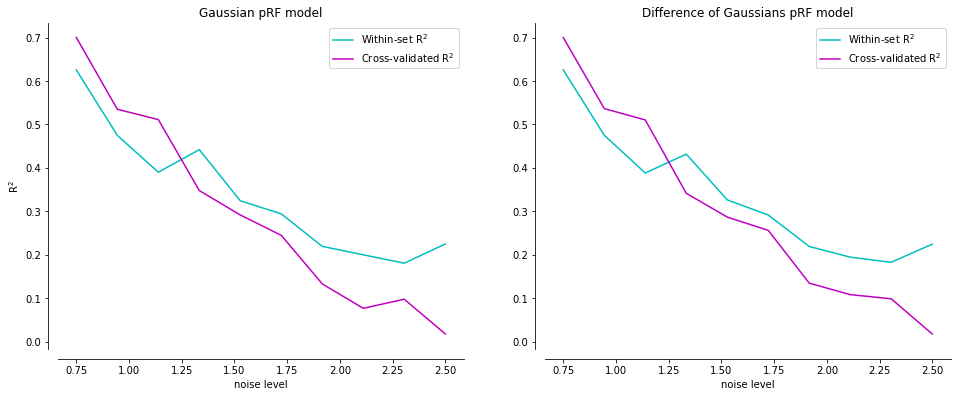

In [173]:
f = plt.figure(figsize=(16,6))
s1 = f.add_subplot(121)
s1.plot(noise_levels, rsqs[:,0], c='c', label='Within-set R$^{2}$')
s1.plot(noise_levels, cv_rsqs[:,0], c='m', label='Cross-validated R$^{2}$')
s1.set_title('Gaussian pRF model')
s1.legend()
s1.set_ylabel('R$^{2}$')
s1.set_xlabel('noise level')
s2 = f.add_subplot(122, sharey=s1)
s2.plot(noise_levels, rsqs[:,1], 'c', label='Within-set R$^{2}$')
s2.plot(noise_levels, cv_rsqs[:,1], 'm', label='Cross-validated R$^{2}$')
s2.set_title('Difference of Gaussians pRF model')
s2.legend()
s2.set_xlabel('noise level')
sns.despine(fig=f, offset=10)

### Questions Assignment

There are some basic outcomes to inspect from this tiny simulation and fitting exercise. You can answer the questions:
- Why is the within-set or out-of-set higher? Go ahead, muse about why this is the case. **Hint:** Think about overfitting!
- Why are the lines for the two models so similar for these simulations?

## Advanced fitting

You have seen that the above analysis already that takes a lot of time, mostly because the analyses are performed serially. Luckily, these fitting procedures can be paralellized over multiple processors. You can find how to do this in the brief explanation of [the possibilities of popeye](https://kdesimone.github.io/popeye/). The open assignment below is for you to re-implement the above quantification of explained variance, but now using paralllel processing. Good luck!